# Conversational agent

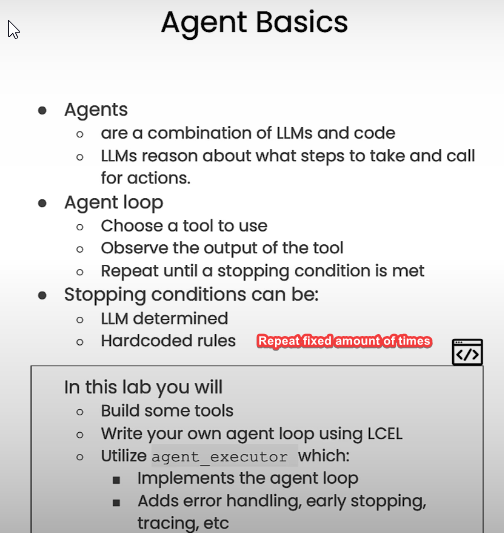

In [1]:
from langchain_core.tools import tool

In [2]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [3]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [4]:
tools = [get_current_temperature, search_wikipedia]

In [5]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [6]:
functions = [convert_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [7]:
result = chain.invoke({"input": "what is the weather is sf?"})

In [8]:
result.tool

'get_current_temperature'

In [9]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

In [10]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [11]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [12]:
result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})

In [13]:
result1

AgentActionMessageLog(tool='get_current_temperature', tool_input={'latitude': 37.7749, 'longitude': -122.4194}, log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-10ae119a-4ada-4964-8977-d0d9dee4fe57-0', usage_metadata={'input_tokens': 112, 'output_tokens': 25, 'total_tokens': 137})])

In [14]:
result1.tool

'get_current_temperature'

In [15]:
observation = get_current_temperature.invoke(result1.tool_input)

In [16]:
observation

'The current temperature is 16.5°C'

In [17]:
type(result1)

langchain_core.agents.AgentActionMessageLog

In [18]:
from langchain.agents.format_scratchpad import format_to_openai_functions

In [19]:
result1.message_log

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-10ae119a-4ada-4964-8977-d0d9dee4fe57-0', usage_metadata={'input_tokens': 112, 'output_tokens': 25, 'total_tokens': 137})]

In [20]:
format_to_openai_functions([(result1, observation), ])

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-10ae119a-4ada-4964-8977-d0d9dee4fe57-0', usage_metadata={'input_tokens': 112, 'output_tokens': 25, 'total_tokens': 137}),
 FunctionMessage(content='The current temperature is 16.5°C', name='get_current_temperature')]

In [21]:
result2 = chain.invoke({
    "input": "what is the weather is sf?", 
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

In [22]:
result2

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 16.5°C.'}, log='The current temperature in San Francisco is 16.5°C.')

In [23]:
from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input, 
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [24]:
from langchain.schema.runnable import RunnablePassthrough

# RunnalbePassthrough takes the initial input and passes it through
# the assign method is creating a new argument to the dictionary that is getting passed through
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [25]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input, 
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [26]:
run_agent("what is the weather is sf?")

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 16.5°C.'}, log='The current temperature in San Francisco is 16.5°C.')

In [27]:
run_agent("what is langchain?")

AgentFinish(return_values={'output': 'LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework with use-cases including document analysis and summarization, chatbots, and code analysis.'}, log='LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework with use-cases including document analysis and summarization, chatbots, and code analysis.')

In [28]:
run_agent("hi!")

AgentFinish(return_values={'output': 'Well, hello there! How can I assist you today?'}, log='Well, hello there! How can I assist you today?')

In [29]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [30]:
agent_executor.invoke({"input": "what is langchain?"})



> Entering new AgentExecutor chain...

Invoking: `search_wikipedia` with `{'query': 'Langchain'}`


Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: Retrieval-augmented generation
Summary: Retrieval augmented generation (RAG) is a type of information retrieval process. It modifies interactions with a large language model (LLM) so that it responds to queries with reference to a specified set of documents, using it in preference to information drawn from its own vast, static training data. This allows LLMs to use domain-specific and/or updated information.  
Use cases include providing chatbot access to internal company data, or giving factual information only from an authoritative source.

Page: D

{'input': 'what is langchain?',
 'output': 'LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework that can be used for document analysis and summarization, chatbots, and code analysis.'}

In [31]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [32]:
agent_executor.invoke({"input": "what is my name"})



> Entering new AgentExecutor chain...
I'm sorry, I don't have access to your personal information. How can I assist you today?

> Finished chain.


{'input': 'what is my name',
 'output': "I'm sorry, I don't have access to your personal information. How can I assist you today?"}

In [33]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [34]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [35]:
from langchain.memory import ConversationBufferMemory

# return messages is set to True so to return list of messages, if set to False it will return str
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")

In [36]:
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [37]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?')],
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [38]:
agent_executor.invoke({"input": "whats my name"})



> Entering new AgentExecutor chain...
Your name is Bob.

> Finished chain.


{'input': 'whats my name',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content='whats my name'),
  AIMessage(content='Your name is Bob.')],
 'output': 'Your name is Bob.'}

In [39]:
agent_executor.invoke({"input": "whats the weather in sf?"})



> Entering new AgentExecutor chain...

Invoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`
responded: I can help you with that. Just give me a moment to fetch the current weather in San Francisco.

The current temperature is 16.5°CThe current temperature in San Francisco is 16.5°C.

> Finished chain.


{'input': 'whats the weather in sf?',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content='whats my name'),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='whats the weather in sf?'),
  AIMessage(content='The current temperature in San Francisco is 16.5°C.')],
 'output': 'The current temperature in San Francisco is 16.5°C.'}